## Evo 2 Yarrowia Sparce Auto Encoder

This notebook shows a **minimal, class‑free** workflow to:

1. **Load Yarrowia** sequence from a local FASTA (`GCF_001761485.1_ASM176148v1_genomic.fna`) and annotations from a local **GFF** (`genomic.gff`).
2. Use the **NVIDIA Evo2 API** to get layer activations for the first **25,000 bases of chromosome 1**.
3. Load a pre‑trained **Top‑K tied Sparse Autoencoder (SAE)** from Hugging Face as **plain tensors** (no Python classes).
4. **Project activations into SAE features** and **plot a handful** of them with GFF annotations.


### Set up imports

In [ ]:
import os, io, base64, json, zipfile, time
import numpy as np
import torch
import matplotlib.pyplot as plt
from Bio import SeqIO
from huggingface_hub import hf_hub_download
import requests
import pandas as pd

# Reproducibility & device
torch.manual_seed(42)
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
dtype = torch.bfloat16  # works well for large tensors
torch.set_grad_enabled(False)

print("Device:", device)

/Users/garrettroell/yarrowia_genome_language_modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps


### Load Evo2 API helper functions

In [2]:
BASE_URL = "https://health.api.nvidia.com/v1/biology"
NVIDIA_API_KEY = os.getenv("NVCF_RUN_KEY") or os.getenv("NVIDIA_API_KEY")
if NVIDIA_API_KEY is None:
    raise RuntimeError("Missing NVIDIA API key. Set NVCF_RUN_KEY or NVIDIA_API_KEY.")

HEADERS = {
    "Authorization": f"Bearer {NVIDIA_API_KEY}",
    "Content-Type": "application/json",
    "Accept": "application/json, application/zip",
    "Prefer": "wait=30",
}

def evo2_forward(sequence, output_layers, model="evo2-7b", timeout_s=1800, max_polls=120):
    """Call Evo2 /forward and return (logits, acts_dict) as numpy arrays.
    No classes; just functions and dicts.
    """
    url = f"{BASE_URL}/arc/{model}/forward"
    # Always ask for 'unembed' so we can pop it later if present
    if "unembed" not in output_layers:
        output_layers = ["unembed"] + list(output_layers)

    payload = {"sequence": sequence, "output_layers": output_layers}
    r = requests.post(url, headers=HEADERS, json=payload, timeout=timeout_s)
    print("Initial status:", r.status_code)

    # Poll 202 with POST (same payload) if needed
    polls = 0
    reqid = r.headers.get("Nvcf-Reqid")
    while r.status_code == 202:
        polls += 1
        retry_after = int(r.headers.get("Retry-After", 10))
        status_hdr  = r.headers.get("Nvcf-Status")
        print(f"[poll {polls}] 202 — status={status_hdr}, retry_after={retry_after}s, reqid={reqid}")
        if polls >= max_polls:
            raise TimeoutError(f"Gave up after {polls} polls (last status={status_hdr}).")
        time.sleep(retry_after)
        poll_headers = dict(HEADERS)
        if reqid:
            poll_headers["Nvcf-Reqid"] = reqid
        r = requests.post(url, headers=poll_headers, json=payload, timeout=timeout_s)

    r.raise_for_status()
    ct = (r.headers.get("Content-Type") or "").lower()
    if "application/zip" in ct or "application/octet-stream" in ct:
        with zipfile.ZipFile(io.BytesIO(r.content), "r") as z:
            names = z.namelist()
            if not names:
                raise RuntimeError("Empty ZIP from server.")
            inner = z.read(names[0])
        resp = json.loads(inner.decode("utf-8", "replace"))
        blob = base64.b64decode(resp["data"])
        npz = np.load(io.BytesIO(blob), allow_pickle=False)
    elif "application/json" in ct:
        resp = r.json()
        blob = base64.b64decode(resp["data"])
        npz = np.load(io.BytesIO(blob), allow_pickle=False)
    else:
        raise RuntimeError(f"Unsupported Content-Type: {ct}")

    def squeeze(x):
        return x[0] if (isinstance(x, np.ndarray) and x.ndim >= 3 and x.shape[0] == 1) else x

    tensors = {k: squeeze(npz[k]) for k in npz.files}
    logits = tensors.pop("unembed", None)
    return logits, tensors


### Load Yarrowia sequence (first 25,000 bases of chromosome 1)

In [3]:
FASTA_PATH = "GCF_001761485.1_ASM176148v1_genomic.fna"   # FASTA
GFF_PATH   = "genomic.gff"                               # GFF annotations

WINDOW_START = 1            # 1-based
WINDOW_END   = 25_000       # inclusive 1..25000

def pick_chr1_record(fasta_path):
    """Return the SeqRecord for chromosome 1 (best effort).
    If not found, return the first record.
    """
    candidates = []
    for rec in SeqIO.parse(fasta_path, "fasta"):
        rid = (rec.id + " " + (rec.description or "")).lower()
        candidates.append(rec)
        if any(tag in rid for tag in ["chromosome 1", "chromosome i", "chr1", "chr 1"]):
            return rec
    # fallback: first record
    return candidates[0]

chr1_rec = pick_chr1_record(FASTA_PATH)
seq_1based = chr1_rec.seq[WINDOW_START-1:WINDOW_END]
sequence = str(seq_1based)
print(chr1_rec.id, "length:", len(chr1_rec.seq))
print("Window length:", len(sequence))
print(sequence[:80] + " ...")


NC_090770.1 length: 2257857
Window length: 25000
AGTCTGGTTTTAGGAACGCCTCCTTGCGAGTgattgtagctacagtatttatTTGTCTTGAGAGCTACCTAAGAGAGCTT ...


### Ask Evo2 for layer activations over this sequence
Potentially, we can look into trying other layer outputs to find different features

In [4]:
SAE_LAYER_NAME = "blocks.26.mlp.l3"  # layer used in the paper examples
wanted_layers = [SAE_LAYER_NAME]

logits, acts = evo2_forward(sequence, output_layers=wanted_layers, model="evo2-7b")
print("Layers returned:", list(acts.keys()))
layer_key = f"{SAE_LAYER_NAME}.output"
layer_act = acts[layer_key]  # shape [T, d_hidden], expected T ~ len(sequence)
print("Layer activations shape:", layer_act.shape)

Initial status: 200
Layers returned: ['blocks.26.mlp.l3.output', 'unembed.output']
Layer activations shape: (25000, 4096)


### Inspect the activation vectors at the output of layer 26

In [5]:
print(f'There are {len(layer_act)} tokens in this sequence window.')
print(f'Each token has {len(layer_act[0])} features. This is the model hidden size or model dimension.')

# make a dataframe of this data with columns: position, base, feature_0, feature_1, ..., feature_n
df = pd.DataFrame(layer_act, columns=[f'feature_{i}' for i in range(layer_act.shape[1])])
df.insert(0, 'base', list(sequence))
df.insert(0, 'position', range(WINDOW_START, WINDOW_END + 1))

df.head(10)

There are 25000 tokens in this sequence window.
Each token has 4096 features. This is the model hidden size or model dimension.


,position,base,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
0,1,A,0.011047,-0.012695,-0.006744,0.000793,-0.006409,-0.002213,0.001389,0.002518,...,0.001968,-0.015137,0.003845,0.012146,0.004730,-0.000036,0.009460,0.002335,0.010315,-0.008484
1,2,G,0.008850,-0.009705,-0.007812,0.008728,-0.011169,-0.005371,-0.000671,-0.007111,...,0.003860,-0.007935,0.005157,0.013489,-0.005798,0.026245,0.015564,0.006531,0.016113,0.002411
2,3,T,0.000128,-0.001854,0.001640,0.000269,-0.001633,-0.003830,-0.000847,-0.000399,...,-0.000656,-0.000767,0.001747,0.003723,-0.001945,0.007874,0.002563,0.002335,0.002411,0.000553
3,4,C,-0.000230,-0.001465,0.001999,-0.001366,-0.001312,-0.003403,-0.001450,0.000118,...,-0.000717,-0.000526,0.001900,0.002502,-0.000782,0.006866,0.002335,0.001671,0.001801,0.001099
4,5,T,0.000071,-0.001564,0.001442,-0.000965,-0.001007,-0.004120,-0.001389,0.000483,...,-0.000710,-0.000744,0.001724,0.003082,-0.000946,0.006958,0.002289,0.002106,0.001915,0.000004
5,6,G,-0.000263,-0.001114,0.001823,-0.001572,-0.001045,-0.003876,-0.001503,0.000538,...,-0.000660,-0.000629,0.001740,0.002228,-0.000523,0.006287,0.001915,0.001663,0.001602,0.000507
6,7,G,-0.000423,-0.000565,0.001823,-0.001427,-0.000942,-0.003220,-0.001068,0.000313,...,-0.000587,-0.000410,0.001434,0.001770,-0.000675,0.005188,0.001610,0.001289,0.001137,0.000675
7,8,T,-0.000256,-0.001503,0.001472,-0.001335,-0.000793,-0.003433,-0.001198,0.000353,...,-0.000778,-0.000290,0.001534,0.002548,-0.000843,0.006042,0.002075,0.001488,0.001465,0.000435
8,9,T,0.007538,-0.027466,0.000500,-0.004181,-0.009644,-0.005554,-0.003113,-0.007935,...,0.003296,-0.011536,-0.005127,0.016235,-0.005737,0.002441,0.006744,-0.005035,0.008667,-0.015198
9,10,T,0.179688,-0.349609,-0.011108,-0.047119,-0.084961,-0.077148,-0.092285,-0.016968,...,0.052246,-0.151367,-0.015076,0.179688,-0.031006,-0.010803,0.129883,-0.107910,0.225586,-0.190430


### Load the Top‑K tied SAE model from from Hugging Face
https://huggingface.co/Goodfire/Evo-2-Layer-26-Mixed

In [6]:
# We'll load the weights and keep them as plain tensors in a dict.
# These weights were trained with expansion_factor=8 and k=64.
SAE_REPO = "Goodfire/Evo-2-Layer-26-Mixed"
SAE_FILE = "sae-layer26-mixed-expansion_8-k_64.pt"

sae_path = hf_hub_download(repo_id=SAE_REPO, filename=SAE_FILE, repo_type="model")
state = torch.load(sae_path, map_location="cpu", weights_only=True)

# Normalize potential key prefixes (strip '_orig_mod.' or 'module.')
clean = {}
for k, v in state.items():
    nk = k.replace("_orig_mod.", "").replace("module.", "")
    clean[nk] = v

# Expected keys: 'W', 'b_enc', 'b_dec'
W     = clean["W"].to(device=device, dtype=dtype)         # [d_in, d_hidden_expanded]
b_enc = clean["b_enc"].to(device=device, dtype=dtype)     # [d_hidden_expanded]
b_dec = clean["b_dec"].to(device=device, dtype=dtype)     # [d_in]
TOP_K = 64

print("W:", tuple(W.shape))
print("b_enc:", tuple(b_enc.shape))
print("b_dec:", tuple(b_dec.shape))


W: (4096, 32768)
b_enc: (32768,)
b_dec: (4096,)


### Define function for running the model (encode/decode helpers)

In [7]:
def relu(x):
    return torch.maximum(x, torch.zeros_like(x))

def encode_topk(x, W, b_enc, k=TOP_K):
    """x: [T, d_in]; returns sparse features f: [T, d_hidden_expanded] with Top‑K per row."""
    # Pre-activation
    f = x @ W + b_enc                  # [T, d_hidden_expanded]
    f = relu(f)

    # Top‑K per row
    # values, idx: [T, k]
    values, idx = torch.topk(f, k=min(k, f.shape[-1]), dim=-1)
    out = torch.zeros_like(f)
    out.scatter_(dim=-1, index=idx, src=values)
    return out

def decode(f, W, b_dec):
    return f @ W.T + b_dec


### Project Evo2 activations through the SAE

In [ ]:

# Convert layer_act (numpy) -> torch
x = torch.tensor(layer_act, device=device, dtype=dtype)   # [T, d_in]
with torch.no_grad():
    f_sparse = encode_topk(x, W, b_enc, k=TOP_K)          # [T, d_hidden_expanded]
    # recon = decode(f_sparse, W, b_dec)                  # optional

feats_np = f_sparse.float().cpu().numpy()
print("SAE feature tensor shape:", feats_np.shape)


SAE feature tensor shape: (25000, 32768)


### Inspect the feats np object

In [9]:
print(f'There are {len(feats_np)} tokens in this sequence window.')
print(f'Each token has {len(layer_act[0])} features. This is the model hidden size or model dimension.')
print(f'Each token embedding was expanded to {feats_np.shape[1]} features by the SAE.')

# convert to a dataframe
df_feats = pd.DataFrame(feats_np, columns=[f'feature_{i}' for i in range(feats_np.shape[1])])
df_feats.insert(0, 'base', list(sequence))
df_feats.insert(0, 'position', range(WINDOW_START, WINDOW_END + 1))
df_feats.head(10)

There are 25000 tokens in this sequence window.
Each token has 4096 features. This is the model hidden size or model dimension.
Each token embedding was expanded to 32768 features by the SAE.


,position,base,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_32758,feature_32759,feature_32760,feature_32761,feature_32762,feature_32763,feature_32764,feature_32765,feature_32766,feature_32767
0,1,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Which features are most active?

In [11]:
# average the features across all tokens,
feature_only_df = df_feats[df_feats.columns[2:]]  # exclude position, base

display(feature_only_df.head())

# loop over the columns and count the number of non-zero entries per feature
nonzero_counts = {}
for col in feature_only_df.columns:
    nonzero_counts[col] = (feature_only_df[col] != 0).sum()

nonzero_counts_series = pd.Series(nonzero_counts)
nonzero_counts_series.sort_values(ascending=False)[:20]  # show top 20 most active features


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_32758,feature_32759,feature_32760,feature_32761,feature_32762,feature_32763,feature_32764,feature_32765,feature_32766,feature_32767
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


feature_29844    25000
feature_32710    16100
feature_15680    13514
feature_8044     13061
feature_24391    12513
feature_11993    12427
feature_17078    10771
feature_2708     10645
feature_5388      8929
feature_18443     8239
feature_27115     8046
feature_16458     7761
feature_11198     7679
feature_7797      7355
feature_24144     7246
feature_302       7235
feature_26908     7150
feature_16242     6853
feature_5722      6845
feature_14899     6789
dtype: int64

### Make a binary version of the feature data frame

In [ ]:
# Make a binary version of the feature data frame
df_feats_binary = df_feats.copy()
for col in df_feats_binary.columns[2:]:  # exclude position, base
    df_feats_binary[col] = (df_feats_binary[col] != 0).astype(int)

df_feats_binary.head()

,position,base,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_32758,feature_32759,feature_32760,feature_32761,feature_32762,feature_32763,feature_32764,feature_32765,feature_32766,feature_32767
0,1,A,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,G,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,T,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,T,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Parse GFF and collect annotations in the 1..25,000 window

In [13]:
# Minimal GFF parser: we keep rows overlapping our window on this chromosome.
def parse_gff_window(gff_path, target_seqid, start_1b, end_1b,
                     keep_types=None):
    if keep_types is None:
        keep_types = {"gene","CDS","exon","mRNA","ncRNA","tRNA","rRNA","misc_feature","Regulatory","tmRNA","mobile_element"}

    out = []
    with open(gff_path, "r", newline="") as fh:
        for line in fh:
            if not line or line.startswith("#"):
                continue
            parts = line.strip().split("	")
            if len(parts) < 9:
                continue
            seqid, source, ftype, start, end, score, strand, phase, attrs = parts
            if seqid != target_seqid:
                continue
            try:
                s = int(start); e = int(end)
            except:
                continue
            if e < start_1b or s > end_1b:
                continue
            if ftype not in keep_types:
                continue
            # Clip to window for plotting
            s_clipped = max(start_1b, s) - start_1b
            e_clipped = min(end_1b,   e) - start_1b
            out.append((s_clipped, e_clipped, ftype, strand, attrs))
    return out

# Try to match the sequence/chromosome name used in GFF to our chosen FASTA record
gff_seqid = chr1_rec.id
ann = parse_gff_window(GFF_PATH, gff_seqid, WINDOW_START, WINDOW_END)

print("Annotations kept:", len(ann))
print("First few:", ann[:5])


Annotations kept: 42
First few: [(1229, 1647, 'gene', '-', 'ID=gene-YALI1_A00014g;Dbxref=GeneID:94582248;Name=YALI1_A00014g;end_range=1648,.;gbkey=Gene;gene_biotype=protein_coding;locus_tag=YALI1_A00014g;partial=true;start_range=.,1230'), (1229, 1647, 'mRNA', '-', 'ID=rna-XM_068281592.1;Parent=gene-YALI1_A00014g;Dbxref=GeneID:94582248,GenBank:XM_068281592.1;Name=XM_068281592.1;end_range=1648,.;gbkey=mRNA;locus_tag=YALI1_A00014g;orig_protein_id=gnl|SandmUCI|YALI1_A00014p;orig_transcript_id=gnl|SandmUCI|mrna.YALI1_A00014p;partial=true;product=uncharacterized protein;start_range=.,1230;transcript_id=XM_068281592.1'), (1522, 1647, 'exon', '-', 'ID=exon-XM_068281592.1-1;Parent=rna-XM_068281592.1;Dbxref=GeneID:94582248,GenBank:XM_068281592.1;end_range=1648,.;gbkey=mRNA;locus_tag=YALI1_A00014g;orig_protein_id=gnl|SandmUCI|YALI1_A00014p;orig_transcript_id=gnl|SandmUCI|mrna.YALI1_A00014p;partial=true;product=uncharacterized protein;transcript_id=XM_068281592.1'), (1229, 1456, 'exon', '-', 'ID=e

### Inspect the annotations

In [14]:
# view annotations as a dataframe
df_ann = pd.DataFrame(ann, columns=["start", "end", "type", "strand", "attributes"])
df_ann

,start,end,type,strand,attributes
0,1229,1647,gene,-,ID=gene-YALI1_A00014g;Dbxref=GeneID:94582248;N...
1,1229,1647,mRNA,-,ID=rna-XM_068281592.1;Parent=gene-YALI1_A00014...
2,1522,1647,exon,-,ID=exon-XM_068281592.1-1;Parent=rna-XM_0682815...
3,1229,1456,exon,-,ID=exon-XM_068281592.1-2;Parent=rna-XM_0682815...
4,1522,1647,CDS,-,ID=cds-XP_068137693.1;Parent=rna-XM_068281592....
5,1229,1456,CDS,-,ID=cds-XP_068137693.1;Parent=rna-XM_068281592....
6,1805,2172,gene,-,ID=gene-YALI1_A00019g;Dbxref=GeneID:94582249;N...
7,1805,2172,mRNA,-,ID=rna-XM_068281593.1;Parent=gene-YALI1_A00019...
8,2010,2172,exon,-,ID=exon-XM_068281593.1-1;Parent=rna-XM_0682815...
9,1805,1962,exon,-,ID=exon-XM_068281593.1-2;Parent=rna-XM_0682815...


### Make a dataframe with columns for position, base, and each annotation as a binary value

In [17]:
# get a list of possible annotation types
annotation_types = df_ann["type"].unique()

print("Annotation types present in the sampled sequence:", annotation_types)

# make a dataframe of zeros with columns for each annotation type
df_ann_binary = pd.DataFrame(0, index=df_feats_binary.index, columns=annotation_types)

# loop over the rows and set the corresponding positions to 1
for index, row in df_ann.iterrows():
    df_ann_binary.loc[row["start"]:row["end"], row["type"]] = 1
df_ann_binary.insert(0, 'base', list(sequence))
df_ann_binary.insert(0, 'position', range(WINDOW_START, WINDOW_END + 1))

display(df_ann_binary.iloc[1510:1530])

Annotation types present in the sampled sequence: ['gene' 'mRNA' 'exon' 'CDS']


,position,base,gene,mRNA,exon,CDS
1510,1511,g,1,1,0,0
1511,1512,t,1,1,0,0
1512,1513,a,1,1,0,0
1513,1514,g,1,1,0,0
1514,1515,t,1,1,0,0
1515,1516,c,1,1,0,0
1516,1517,c,1,1,0,0
1517,1518,a,1,1,0,0
1518,1519,T,1,1,0,0
1519,1520,T,1,1,0,0


### Add annotations to the df_feats_binary dataframe

In [18]:
# Add annotations to the df_feats_binary dataframe
df_feats_ann_binary = pd.concat([df_ann_binary, df_feats_binary], axis=1)

df_feats_ann_binary

,position,base,gene,mRNA,exon,CDS,position,base,feature_0,feature_1,...,feature_32758,feature_32759,feature_32760,feature_32761,feature_32762,feature_32763,feature_32764,feature_32765,feature_32766,feature_32767
0,1,A,0,0,0,0,1,A,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,G,0,0,0,0,2,G,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,T,0,0,0,0,3,T,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,C,0,0,0,0,4,C,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,T,0,0,0,0,5,T,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996,t,0,0,0,0,24996,t,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,24997,g,0,0,0,0,24997,g,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,24998,t,0,0,0,0,24998,t,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,24999,t,0,0,0,0,24999,t,0,0,...,0,0,0,0,0,0,0,0,0,0


### Analyze the correlations between the features and the annotations

In [ ]:
# get the annotation and feature columns
annotation_cols = df_ann_binary.columns[2:]  # exclude position, base
feature_cols = [col for col in df_feats_ann_binary.columns if col.startswith("feature_")]

# make simplified dataframes
annotations = df_feats_ann_binary[annotation_cols]
features = df_feats_ann_binary[feature_cols]

# dictionary to hold correlation results
correlation_results = {}

# loop over the annotation columns and compute correlation with each feature
for ann in annotation_cols:
    corr = features.corrwith(annotations[ann])  # computes correlation column-wise
    correlation_results[ann] = corr

corr_df = pd.DataFrame(correlation_results)

corr_df

/Users/garrettroell/yarrowia_genome_language_modeling/venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/garrettroell/yarrowia_genome_language_modeling/venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,gene,mRNA,exon,CDS
feature_0,NaN,NaN,NaN,NaN
feature_1,0.001874,0.001874,0.002638,0.002638
feature_2,NaN,NaN,NaN,NaN
feature_3,-0.004608,-0.004608,-0.004544,-0.004544
feature_4,NaN,NaN,NaN,NaN
...,...,...,...,...
feature_32763,NaN,NaN,NaN,NaN
feature_32764,NaN,NaN,NaN,NaN
feature_32765,NaN,NaN,NaN,NaN
feature_32766,NaN,NaN,NaN,NaN


### Find the features with the highest correlations to each annotation

In [ ]:
# Find the features with the highest correlations to each annotation
# loop over the annotation columns and get top correlated features
corr_df['gene'].sort_values(ascending=False)[:1]  # top 10 features correlated with 'gene' annotation

feature_15809    0.293058
Name: gene, dtype: float64

### Plot a handful of SAE features with GFF overlays

In [42]:
feats_np.shape

(25000, 32768)

ValueError: not enough values to unpack (expected 5, got 1)

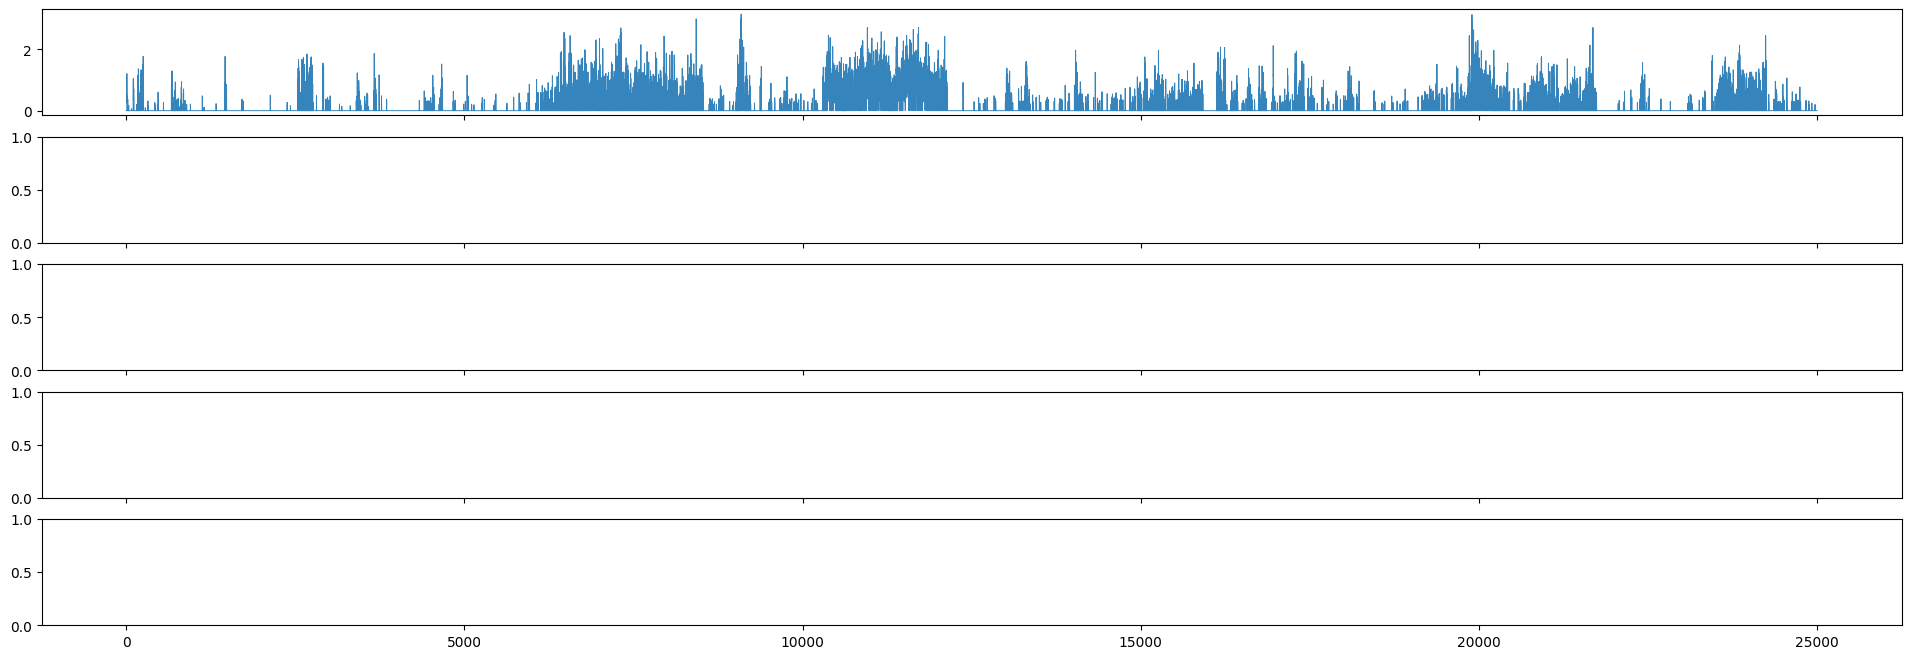

In [41]:

# Choose a few feature indices to visualize (change to taste)
# selected_features = [15680, 28339, 1050, 25666]
selected_features = [15809, 15809, 15809, 15809, 15809]

ANNOTATION_COLORS = {
    'CDS': 'lightyellow',
    'gene': 'lightgray', 
    'mobile_element': 'lightgreen',
    'misc_feature': 'khaki',
    'rRNA': '#7AC8AC',
    'tRNA': '#662D91',
    'ncRNA': 'white',
    'Regulatory': 'lightcoral',
    'tmRNA': 'salmon',
    'exon': 'lightblue',
    'mRNA': 'lavender'
}

T = feats_np.shape[0]
fig, axes = plt.subplots(len(selected_features), 1, figsize=(24, 1.6*len(selected_features)), sharex=True)

for i, feat_id in enumerate(selected_features):
    ax = axes[i] if len(selected_features) > 1 else axes
    if feat_id >= feats_np.shape[1]:
        ax.text(0.01, 0.5, f"Feature {feat_id} out of range", transform=ax.transAxes)
        continue
    ax.plot(feats_np[:, feat_id], lw=0.7, label=f"feature {feat_id}", alpha=0.9)
    for s, e, ftype, strand, attrs in ann:
        ax.axvspan(s, e, color=ANNOTATION_COLORS.get(ftype, 'lightgray'), alpha=0.25)
    ax.set_xlim(0, T)
    ax.set_yticks([0, max(0.1, feats_np[:, feat_id].max())])
    ax.legend(loc="upper right", frameon=False)

plt.xlabel("Position (bp) in 1..25,000 window")
plt.show()



### Tips / Next steps
- Change `SAE_LAYER_NAME` to probe different hidden layers.
- Adjust `selected_features` to scan for interesting peaks.
- Expand `WINDOW_END` or slide `WINDOW_START` to explore more of chromosome 1.
- Save `feats_np` and overlay other tracks (GC%, motif hits, etc.).
